# Set Up Env


In [1]:
import sys
import os

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/jenna/phase_2


# Import libraries


In [2]:
# standard libraries
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

!pip install seaborn -q
import seaborn as sns

# Download Data from S3 as needed


In [3]:
# link = "CRSP/link_crsp_and_comp_2018-2023.csv"
# link_path = s3_download(link)

In [4]:
# index = "Index/security_master.csv"
# index_path = s3_download(index)

# Load the dataset

https://wrds-www.wharton.upenn.edu/documents/403/CRSP_-_Compustat_Merged_Database_CCM_NiIeIWV.pdf


In [5]:
link_df = pd.read_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/link_crsp_and_comp_2018-2023.csv",
    parse_dates=["srcdate"],
    low_memory=False
)

link_df.head()

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,stype,sid,...,snms,soptp1,soptp2,conm,tic,cusip,cik,sic,naics,gsubind
0,1004,P,1,LU,54594,20000,1972-04-24,E,BUSSEG,22,...,Expeditionary Services,PD_SRVC,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
1,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,5,...,Europe/Africa,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
2,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,4,...,North America,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
3,1004,P,1,LU,54594,20000,1972-04-24,E,BUSSEG,11,...,Corporate,PD_SRVC,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0
4,1004,P,1,LU,54594,20000,1972-04-24,E,GEOSEG,3,...,Other,GEO,NaN,AAR CORP,AIR,000361105,1750.0,5080,423860,20101010.0


# Take a look at the columns


In [6]:
link_df.columns

Index(['GVKEY', 'LINKPRIM', 'LIID', 'LINKTYPE', 'LPERMNO', 'LPERMCO', 'LINKDT',
       'LINKENDDT', 'stype', 'sid', 'atlls', 'capxs', 'capxs_fn', 'caxts',
       'cogss', 'dps', 'emps', 'emps_fn', 'esubs', 'esubs_fn', 'ias', 'ibs',
       'iints', 'intseg', 'ivaeqs', 'nis', 'nopxs', 'nxints', 'obs', 'ocaxs',
       'oelim', 'oiadps', 'oibdps', 'ops', 'ops_fn', 'ppents', 'ptis', 'rds',
       'rds_fn', 'revts', 'sales', 'sales_fn', 'salexg', 'spis', 'txts',
       'txws', 'xidos', 'xints', 'xsgas', 'datadate', 'srcdate', 'curcds',
       'isosrc', 'naicsh', 'srcs', 'upds', 'NAICSS1', 'NAICSS2', 'SICS1',
       'SICS2', 'geotp', 'snms', 'soptp1', 'soptp2', 'conm', 'tic', 'cusip',
       'cik', 'sic', 'naics', 'gsubind'],
      dtype='object')

In [7]:
link_df.dtypes

GVKEY         int64
LINKPRIM     object
LIID          int64
LINKTYPE     object
LPERMNO       int64
             ...   
cusip        object
cik         float64
sic           int64
naics         int64
gsubind     float64
Length: 71, dtype: object

In [8]:
og_link_len = len(link_df)
og_link_cols = len(link_df.columns)
print("number of records:", og_link_len)
print("number of columns:", og_link_cols)

number of records: 315578
number of columns: 71


# Cast date variables

In [9]:
def date_formatting(df):
    """Convert to datetime with specified format"""
    date_columns = [
        "LINKDT",
        "LINKENDDT",
        "datadate",
        "srcdate",
    ]
    for col in date_columns:
        if col in df.columns:
            # First, try with a common format
            try:
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='raise')
            except ValueError:
                # If that fails, try with another common format
                try:
                    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y', errors='raise')
                except ValueError:
                    # If both fail, use the flexible parser as a last resort
                    df[col] = pd.to_datetime(df[col], errors='coerce')
            
            # Handle any remaining NaT values
            df[col] = df[col].fillna(pd.NaT)
    
    return df

# Apply the function
link_df = date_formatting(link_df)

# Sort the df by date for forward fill preparation
link_df = link_df.sort_values('srcdate')

/tmp/ipykernel_5044/605713236.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


# Null analysis


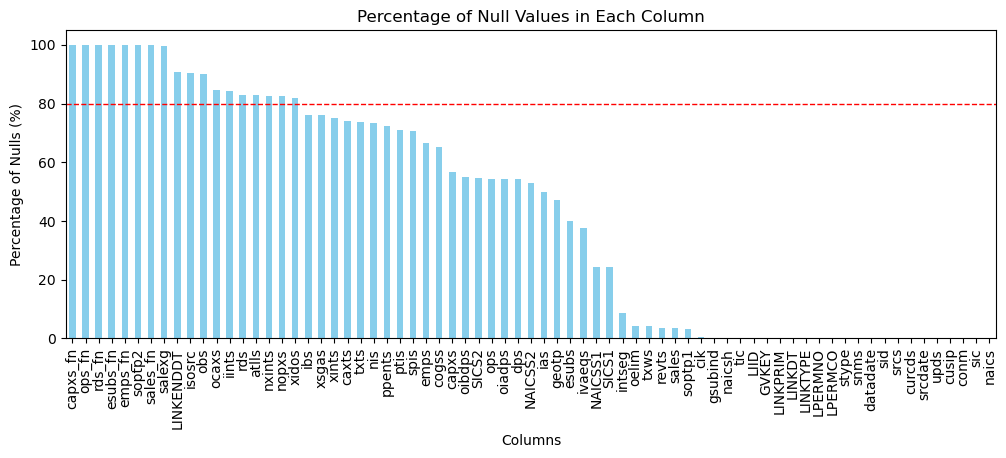

In [10]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.axhline(y=80, color="red", linestyle="--", linewidth=1)
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of Nulls (%)")
plt.show()

## A1. Drop all columns which contains more than 80% null as they cannot be reasonably obtained or imputed.


In [11]:
og_cols = len(link_df.columns)
columns_to_drop = null_percentages[null_percentages > 80].index
link_df = link_df.drop(columns=columns_to_drop)
new_cols = len(link_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  18
num_columns_kept: 53


## A2. Drop all columns containing duplicate information and columns just used for linking


In [12]:
og_cols = len(link_df.columns)
columns_to_drop = [
    "LPERMCO",  # Redundant with LPERMNO
    "LIID",     # Redundant with LPERMNO
    "naicsh",   # Historical NAICS
    "GVKEY",    # Just used for linking Compustat
    "NAICSS1",  # Just used for linking Compustat
    "NAICSS2",  # Just used for linking Compustat
    "SICS1",    # Just used for linking Compustat
    "SICS2",    # Just used for linking Compustat
    "LINKTYPE", # Just used for linking Compustat
    "LINKPRIM", # Just used for linking Compustat
    "datadate", # srcdate as primary date
    "LINKDT",   # srcdate as primary date
    "curcds",   # Currency codes
    "srcs",     # Just used for linking Compustat
    "tic",      # LPERMNO as your primary identifier
    "cusip",    # LPERMNO as primary identifier
    "sic",      # redundant to naics
]

link_df = link_df.drop(columns=columns_to_drop)
new_cols = len(link_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  17
num_columns_kept: 36


# Take another look at the null analysis


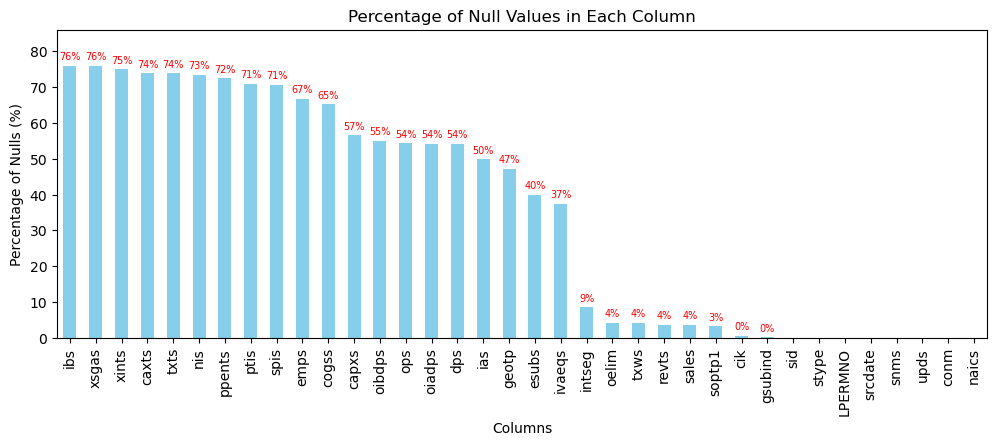

In [13]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
            fontsize=7,
        )

plt.show()

# Review unique values and distribution in each remaining column


In [14]:
for column in link_df.columns:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

---------- LPERMNO ----------
6663
LPERMNO
85261    612
14785    461
33823    439
86111    431
91607    416
        ... 
24087      1
21825      1
21025      1
23801      1
22193      1
Name: count, Length: 6663, dtype: int64
---------- stype ----------
4
stype
GEOSEG    152347
BUSSEG    134561
OPSEG      28272
STSEG        398
Name: count, dtype: int64
---------- sid ----------
90
sid
1     76479
2     37195
3     27126
4     22270
5     18877
      ...  
83        1
74        1
79        1
73        1
71        1
Name: count, Length: 90, dtype: int64
---------- capxs ----------
23508
capxs
0.000       22397
1.000         358
2.000         311
3.000         230
5.000         227
            ...  
646.851         1
39.459          1
1490.866        1
131.973         1
1808.952        1
Name: count, Length: 23508, dtype: int64
---------- caxts ----------
30001
caxts
0.000      566
237.000     19
511.000     19
51.000      17
199.000     16
          ... 
9.571        1
5.262        1
20

# Review revts: total revenue
This item represents the gross income received from all divisions of the company in an industry segment

## B1. Check abnormal values


In [15]:
column = "revts"

print("-" * 10, column, "-" * 10)
print(link_df[column].nunique())
print(link_df[column].value_counts())

---------- revts ----------
93393
revts
0.000      28397
2.000         98
1.000         86
3.000         82
7.000         72
           ...  
126.067        1
41.738         1
740.322        1
847.920        1
91.192         1
Name: count, Length: 93393, dtype: int64


In [16]:
link_df['revts'].describe()

count    304078.000000
mean       2345.641960
std       11783.229417
min      -54607.000000
25%          17.905000
50%         188.193500
75%        1033.800000
max      508685.000000
Name: revts, dtype: float64

In [17]:
negative_revts = link_df[link_df['revts'] < 0]
negative_percentage = (link_df['revts'] < 0).mean() * 100
print(f"Number of negative revts values: {len(negative_revts)}")
print("\nSample of negative revts values:")
print(negative_revts[['LPERMNO', 'srcdate', 'revts']].head())
print(f"Percentage of rows with negative 'revts' values: {negative_percentage:.2f}%")

Number of negative revts values: 3100

Sample of negative revts values:
        LPERMNO    srcdate     revts
19007     76708 2018-06-30    -2.592
263167    13196 2018-06-30    -1.263
5524      44644 2018-06-30  -619.200
301174    84603 2018-06-30    -1.520
301167    84603 2018-06-30 -2086.748
Percentage of rows with negative 'revts' values: 0.98%


## B2. Remove negative values - less than 1% of DF

In [18]:
# Remove negative values
link_df = link_df[link_df['revts'] >= 0]

# Take another look at nulls

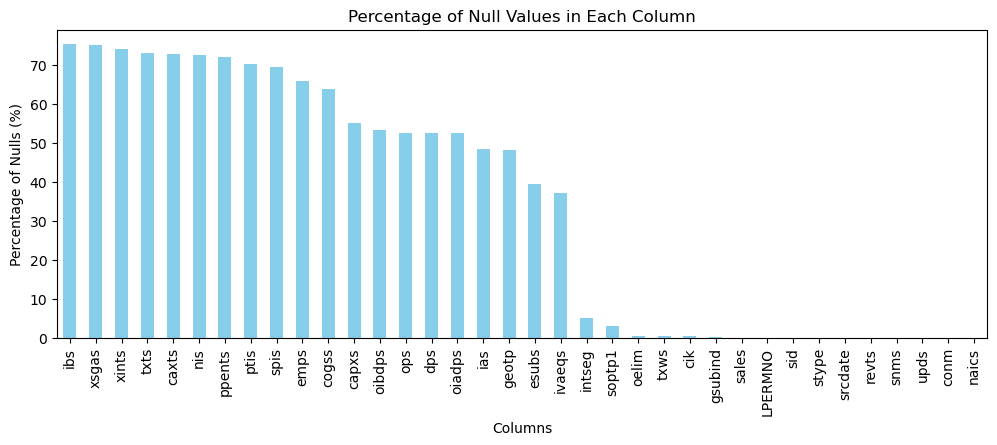

In [19]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Percentage of Nulls (%)")
plt.show()

In [20]:
null_percentages

ibs        75.220780
xsgas      75.035052
xints      74.058901
txts       73.037564
caxts      72.818279
nis        72.616603
ppents     71.976357
ptis       70.109775
spis       69.539966
emps       65.815109
cogss      63.810976
capxs      55.055187
oibdps     53.288612
ops        52.513473
dps        52.493870
oiadps     52.480248
ias        48.449056
geotp      48.148702
esubs      39.404209
ivaeqs     37.070151
intseg      5.105024
soptp1      2.880277
oelim       0.513659
txws        0.486414
cik         0.464818
gsubind     0.103330
sales       0.000332
LPERMNO     0.000000
sid         0.000000
stype       0.000000
srcdate     0.000000
revts       0.000000
snms        0.000000
upds        0.000000
conm        0.000000
naics       0.000000
dtype: float64

# Review soptp1 - operating segment type

Dataset is organized by segement


## C1. Fill soptp1 na with Unknown


In [21]:
# Check the percentage of nulls in the sales column
null_percentage = (link_df['soptp1'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in soptp1 column: {null_percentage:.2f}%")

Percentage of null values in soptp1 column: 2.88%


In [22]:
link_df["soptp1"] = link_df["soptp1"].fillna("UNKNOWN")

# Review identifier codes: cik (Central Index Key)

Generic column - identifier

## D1. Fill cik with "NO_CIK"


In [23]:
# Check the percentage of nulls in the CIK column
null_percentage = (link_df['cik'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in CIK column: {null_percentage:.2f}%")

Percentage of null values in CIK column: 0.46%


In [24]:
# Fill with a placeholder value
link_df['cik'] = link_df['cik'].fillna('NO_CIK')

In [25]:
# Check the percentage of nulls in the CIK column
null_percentage = (link_df['cik'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in CIK column: {null_percentage:.2f}%")

Percentage of null values in CIK column: 0.00%


# Review geotp - Geographic Segment Type


## E1. geotp - change codes to readable

In [26]:
# Create a mapping dictionary for geotp
geotp_mapping = {
    2.0: "DOMESTIC",
    3.0: "NON-DOMESTIC",
    np.nan: "UNKNOWN"
}

# Apply the mapping to the geotp column
link_df["geotp"] = link_df["geotp"].map(geotp_mapping).fillna("UNKNOWN")

# Check the unique values in the geotp column to verify the changes
print(link_df["geotp"].value_counts(dropna=False))

geotp
UNKNOWN         144917
NON-DOMESTIC    101495
DOMESTIC         54566
Name: count, dtype: int64


In [27]:
# Check the percentage of nulls in the geotp column
null_percentage = (link_df['geotp'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in geotp column: {null_percentage:.2f}%")

Percentage of null values in geotp column: 0.00%


# Take another look at the null analysis


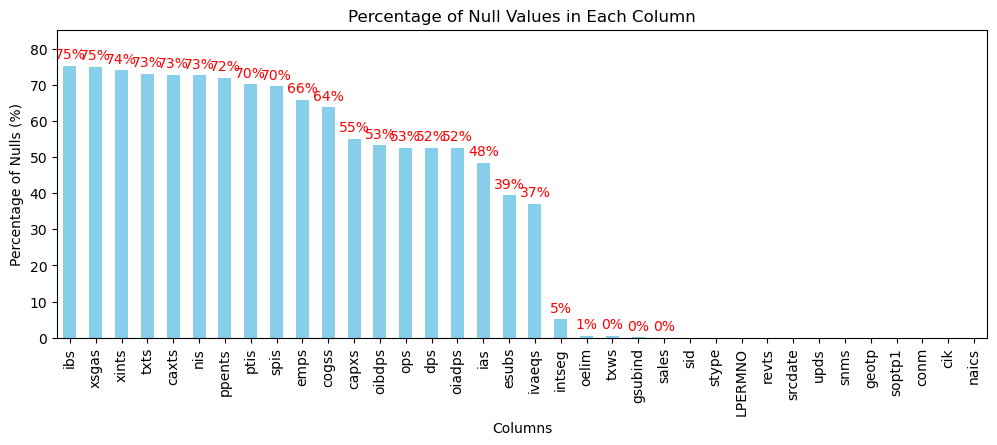

In [28]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

# Plot the percentages as a bar plot
ax = null_percentages.plot(kind="bar", figsize=(12, 4), color="skyblue")
plt.title("Percentage of Null Values in Each Column")
plt.xlabel("Columns")
plt.ylim(0, max(null_percentages.values) + 10)
plt.ylabel("Percentage of Nulls (%)")

# Annotate the bars with the percentage values
for i, percentage in enumerate(null_percentages):
    if percentage != 0:
        ax.annotate(
            f"{percentage:.0f}%",
            xy=(i, percentage),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            color="red",
        )

plt.show()

In [29]:
null_percentages

ibs        75.220780
xsgas      75.035052
xints      74.058901
txts       73.037564
caxts      72.818279
nis        72.616603
ppents     71.976357
ptis       70.109775
spis       69.539966
emps       65.815109
cogss      63.810976
capxs      55.055187
oibdps     53.288612
ops        52.513473
dps        52.493870
oiadps     52.480248
ias        48.449056
esubs      39.404209
ivaeqs     37.070151
intseg      5.105024
oelim       0.513659
txws        0.486414
gsubind     0.103330
sales       0.000332
sid         0.000000
stype       0.000000
LPERMNO     0.000000
revts       0.000000
srcdate     0.000000
upds        0.000000
snms        0.000000
geotp       0.000000
soptp1      0.000000
conm        0.000000
cik         0.000000
naics       0.000000
dtype: float64

# Review naics: North American Industry Classification System Code

North American Industry Classification System Code (NAICS) is an 6-character code used to group companies with similar products or services.

NAICS is a hierachical code, containing up to six digits: The first two fields, NAICS sectors, designate general categories of economic activity, the third field, sub-sector, further defines the sector, the fourth field is the industry group, the fifth field is the NAICS industry, and the sixth field represents the national industry (a zero in the 6th digit generally indicates that the NAICS industry and teh country industry are the same).


## F1. Fill naics na with 999999 as "Unknown"


In [30]:
link_df["naics"] = link_df["naics"].fillna("999999")

## F2. Split naics to two columns ['NAICS_Sector', 'NAICS_Secondary']


In [31]:
link_df["NAICS_Sector"] = link_df["naics"].astype(str).str[:2]
link_df["NAICS_Secondary"] = link_df["naics"].astype(str).str[2:]

In [32]:
for column in ["NAICS_Sector", "NAICS_Secondary"]:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

---------- NAICS_Sector ----------
23
NAICS_Sector
33    78334
32    40870
52    39190
51    33198
21    16955
53    14117
31    11022
54     9766
42     8165
48     7234
22     6828
56     6022
45     5274
23     5030
72     4383
62     3301
44     3230
61     2343
99     1862
71     1836
11      974
81      558
49      486
Name: count, dtype: int64
---------- NAICS_Secondary ----------
512
NAICS_Secondary
2110    17026
5414    12298
8210     9696
1120     8593
4413     8467
        ...  
35          3
1419        3
229         3
1940        2
999         1
Name: count, Length: 512, dtype: int64


## F3. Clean-up the NAICS sector column to readable format

https://www.census.gov/naics/reference_files_tools/2022_NAICS_Manual.pdf


In [33]:
sector_dict = {
    "10": "Metal Mining",
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "32": "Manufacturing",
    "33": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "45": "Retail Trade",
    "48": "Transportation and Warehousing",
    "49": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental and Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative and Support and Waste Management and Remediation Services",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "67": "Holding And Other Investment Offices",
    "71": "Arts, Entertainment, and Recreation",
    "72": "Accommodation and Food Services",
    "73": "Business Services",
    "81": "Other Services (except Public Administration)",
    "92": "Public Administration",
    "99": "Unknown",
}

link_df["NAICS_Sector_Name"] = link_df["NAICS_Sector"].replace(sector_dict)

In [34]:
print(link_df["NAICS_Sector_Name"].value_counts())

NAICS_Sector_Name
Manufacturing                                                               130226
Finance and Insurance                                                        39190
Information                                                                  33198
Mining, Quarrying, and Oil and Gas Extraction                                16955
Real Estate and Rental and Leasing                                           14117
Professional, Scientific, and Technical Services                              9766
Retail Trade                                                                  8504
Wholesale Trade                                                               8165
Transportation and Warehousing                                                7720
Utilities                                                                     6828
Administrative and Support and Waste Management and Remediation Services      6022
Construction                                                         

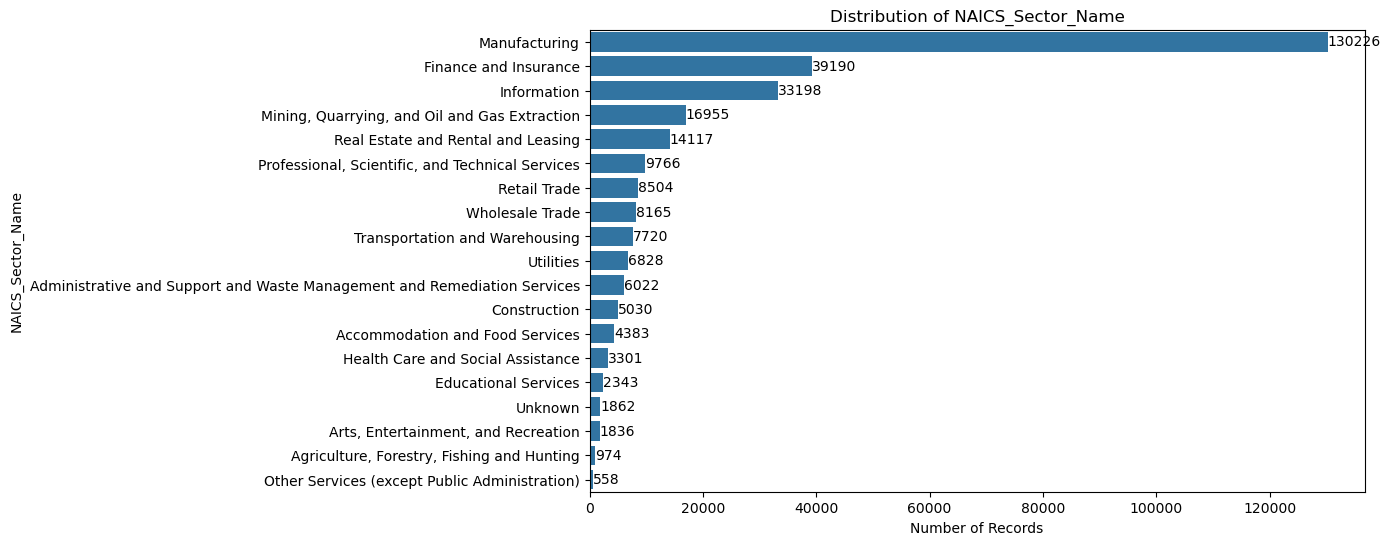

In [35]:
# Calculate the category counts and sort them in descending order
category_counts = link_df["NAICS_Sector_Name"].value_counts().sort_values(ascending=False)

# Plot the counts distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=link_df, y="NAICS_Sector_Name", order=category_counts.index)
plt.title("Distribution of NAICS_Sector_Name")
plt.xlabel("Number of Records")
plt.ylabel("NAICS_Sector_Name")

# Annotate the bars with the count values
for i, count in enumerate(category_counts):
    plt.text(count, i, f"{count}", ha="left", va="center", color="black")

plt.show()

# Review upds - Update codes

## G1. change codes to readable format

This item contains the code that identifies the updated status of data for the period for the industry segment. It consists of one of the following one-character numeric codes

Update Code 2 on annual updates indicates:

- Company has suspended trading and only partial financial data is available
- Red Herring filings
- Company is undergoing accounting review and they may issue only newswire information for successive periods until the accounts are in order
- Source is a newswire and/or incomplete financials information

Update Code 3 on annual updates indicates:

- 10K and/or an annual report is used for an update and historically no additional data is obtained from other sources.
- A year has been updated with a preliminary source and there is an indication that the final source will not be available (for example, when a company is de-listed from the exchange and stops filing 10Ks.)
- Preliminary updates will be finalized six months after the fiscal year end for U.S. companies (nine months after the fiscal year end for ADR companies), even if additional sources are not received.
- An update is being done six months after the company's fiscal year end for domestic American companies (nine months for ADR companies) even though additional data is historically obtained from a source not available in the current year.

In [36]:
column = "upds"

print("-" * 10, column, "-" * 10)
print(link_df[column].nunique())
print(link_df[column].value_counts())

---------- upds ----------
2
upds
3    300933
2        45
Name: count, dtype: int64


In [37]:
# Check the percentage of nulls in the upds column
null_percentage = (link_df['upds'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in upds column: {null_percentage:.2f}%")

Percentage of null values in upds column: 0.00%


In [38]:
# Create a mapping dictionary for upds
upds_mapping = {
    3: "FINAL_DATA",
    2: "PRE-LIMINARY_DATA",
    np.nan: "UNKNOWN"
}

# Apply the mapping to the upds column
link_df["upds"] = link_df["upds"].map(upds_mapping).fillna("UNKNOWN")

# Check the unique values in the upds column to verify the changes
print(link_df["upds"].value_counts(dropna=False))

upds
FINAL_DATA           300933
PRE-LIMINARY_DATA        45
Name: count, dtype: int64


## G2. Only keep rows with reliable data

In [39]:
og_len = len(link_df)
link_df = link_df[link_df["upds"] == "FINAL_DATA"].reset_index(drop=True)
new_len = len(link_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

num_records_removed:  45
num_records_kept:  300933


# Review gsubind: GICS Sub-Industries Variable Name

This item represents the fourth level in the hierarchy of the Global Industry Classification Standard (GICS). The Sub-industry is represented by all 8 digits of the total GICS code.

In [40]:
column = "gsubind"

print("-" * 10, column, "-" * 10)
print(link_df[column].nunique())
print(link_df[column].value_counts())

---------- gsubind ----------
177
gsubind
40101015.0    13099
35201010.0    12296
45103010.0    10683
35101010.0     8399
20106020.0     7930
              ...  
60101050.0       26
20304020.0       18
25503010.0        5
25503020.0        4
60102040.0        2
Name: count, Length: 177, dtype: int64


In [41]:
# Check the percentage of nulls in the gsubind column
null_percentage = (link_df['gsubind'].isnull().sum() / len(link_df)) * 100
print(f"Percentage of null values in gsubind column: {null_percentage:.2f}%")

Percentage of null values in gsubind column: 0.10%


## H1. Fill gsubind na with 999999 as "Unknown"

In [42]:
link_df["gsubind"] = link_df["gsubind"].fillna("999999")

## H2. Split naics to two columns ['GICS_Sector', 'GICS_Secondary']

In [43]:
link_df["GICS_Sector"] = link_df["gsubind"].astype(str).str[:2]
link_df["GICS_Secondary"] = link_df["gsubind"].astype(str).str[2:]

In [44]:
for column in ["GICS_Sector", "GICS_Secondary"]:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

---------- GICS_Sector ----------
12
GICS_Sector
20    49219
45    45277
40    40025
35    38779
25    35167
15    25696
10    17759
50    16348
30    13605
60    11666
55     7081
99      311
Name: count, dtype: int64
---------- GICS_Secondary ----------
79
GICS_Secondary
101010.0    29066
203010.0    18516
103010.0    18450
201010.0    16691
202010.0    15855
            ...  
101070.0       85
101080.0       75
304020.0       18
503010.0        5
503020.0        4
Name: count, Length: 79, dtype: int64


## H3. Clean-up the GICS sector column to readable format

https://www.spglobal.com/marketintelligence/en/documents/112727-gics-mapbook_2018_v3_letter_digitalspreads.pdf

In [45]:
gics_sector_dict = {
    "10": "Energy",
    "15": "Materials",
    "20": "Industrials",
    "25": "Consumer Discretionary",
    "30": "Consumer Staples",
    "35": "Health Care",
    "40": "Financials",
    "45": "Information Technology",
    "50": "Communication Services",
    "55": "Utilities",
    "60": "Real Estate",
    "99": "Unknown"  # Added for unknown sectors
}

In [46]:
link_df["GICS_Sector_Name"] = link_df["GICS_Sector"].replace(gics_sector_dict)

In [47]:
print(link_df["GICS_Sector_Name"].value_counts())

GICS_Sector_Name
Industrials               49219
Information Technology    45277
Financials                40025
Health Care               38779
Consumer Discretionary    35167
Materials                 25696
Energy                    17759
Communication Services    16348
Consumer Staples          13605
Real Estate               11666
Utilities                  7081
Unknown                     311
Name: count, dtype: int64


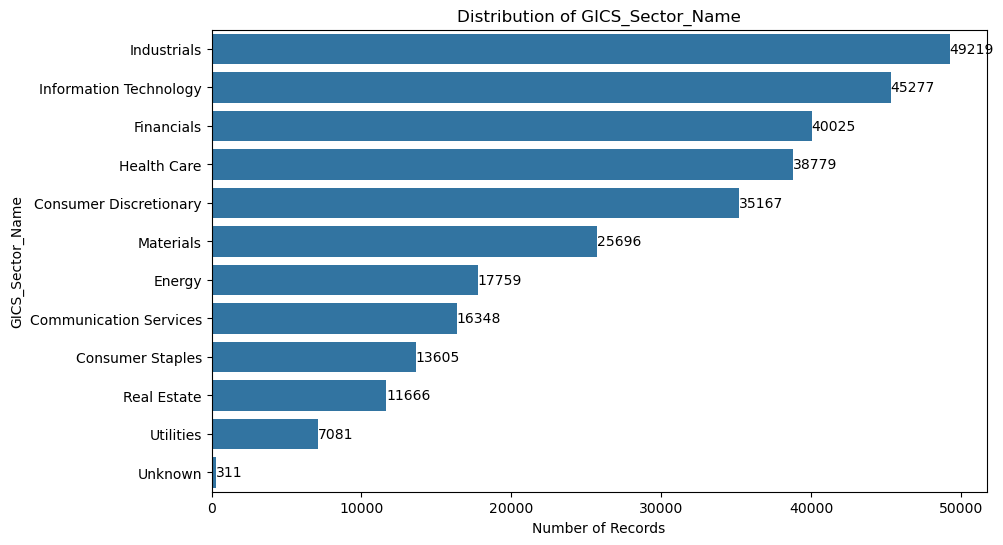

In [48]:
# Calculate the category counts and sort them in descending order
category_counts = link_df["GICS_Sector_Name"].value_counts().sort_values(ascending=False)

# Plot the counts distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=link_df, y="GICS_Sector_Name", order=category_counts.index)
plt.title("Distribution of GICS_Sector_Name")
plt.xlabel("Number of Records")
plt.ylabel("GICS_Sector_Name")

# Annotate the bars with the count values
for i, count in enumerate(category_counts):
    plt.text(count, i, f"{count}", ha="left", va="center", color="black")

plt.show()

# Review all remaining value related columns.


## I2. Forward fill prep

### Check to see if negative values should be there

In [49]:
def to_numeric_with_errors(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [50]:
# Columns that can potentially have negative values
can_be_negative = [
    'ibs', 'xsgas', 'xints', 'txts', 'nis',
    'ptis','oibdps', 'ops', 'oiadps', 'oelim', 'spis',
]

# Columns that should not have negative values
should_be_positive = [
    'caxts', 'ppents', 'emps', 'cogss', 'capxs', 'dps', 'ias', 'esubs', 
    'ivaeqs', 'intseg', 'txws', 'gsubind', 'sales'
]

# Convert all relevant columns to numeric
all_columns_to_check = can_be_negative + should_be_positive
link_df = to_numeric_with_errors(link_df, all_columns_to_check)

def check_negatives(df, column_list, expected_negative=True):
    for col in column_list:
        if col in df.columns:
            neg_count = (df[col] < 0).sum()
            neg_percentage = (neg_count / df[col].count()) * 100
            if expected_negative:
                print(f"{col}: {neg_count} negative values ({neg_percentage:.2f}%)")
            else:
                if neg_count > 0:
                    print(f"Warning: {col} has {neg_count} negative values ({neg_percentage:.2f}%)")
                else:
                    print(f"{col}: No negative values (as expected)")
        else:
            print(f"{col} not found in the dataframe")

print("Checking columns that can have negative values:")
check_negatives(link_df, can_be_negative)

print("\nChecking columns that should not have negative values:")
check_negatives(link_df, should_be_positive, expected_negative=False)

Checking columns that can have negative values:
ibs: 30823 negative values (41.33%)
xsgas: 548 negative values (0.73%)
xints: 1319 negative values (1.69%)
txts: 14014 negative values (17.27%)
nis: 33749 negative values (40.96%)
ptis: 35050 negative values (38.96%)
oibdps: 41611 negative values (29.60%)
ops: 49572 negative values (34.69%)
oiadps: 49506 negative values (34.62%)
oelim: 6 negative values (0.00%)
spis: 54431 negative values (59.38%)

Checking columns that should not have negative values:
emps: No negative values (as expected)
gsubind: No negative values (as expected)


In [51]:
# # Columns to check and potentially modify
# columns_to_check = ['caxts', 'ppents', 'cogss', 'capxs', 'dps', 
#                     'ias', 'esubs', 'ivaeqs', 'intseg', 'txws', 'sales']

# for col in columns_to_check:    
#         # Replace negative values with zero for columns with less than 5% negative values
#         neg_percentage = (link_df[col] < 0).mean() * 100
#         if neg_percentage < 5:
#             link_df[col] = link_df[col].clip(lower=0)
#             print(f"Replaced negative values with zero in {col}")
#         else:
#             print(f"Column {col} has {neg_percentage:.2f}% negative values. Further investigation recommended.")

Replaced negative values with zero in caxts
Replaced negative values with zero in ppents
Replaced negative values with zero in cogss
Replaced negative values with zero in capxs
Replaced negative values with zero in dps
Replaced negative values with zero in ias
Replaced negative values with zero in esubs
Replaced negative values with zero in ivaeqs
Replaced negative values with zero in intseg
Replaced negative values with zero in txws
Replaced negative values with zero in sales


In [52]:
# pick an example for visual inspection
review_idx = link_df[link_df["txts"].isnull()].index[0]
link_df[link_df["txts"].isnull()].iloc[0]

LPERMNO                                    29612
stype                                     BUSSEG
sid                                            4
capxs                                        0.0
caxts                                        NaN
cogss                                        NaN
dps                                          0.0
emps                                         NaN
esubs                                        0.0
ias                                          0.0
ibs                                          NaN
intseg                                       0.0
ivaeqs                                       0.0
nis                                          NaN
oelim                                        0.0
oiadps                                     37.98
oibdps                                     37.98
ops                                        37.98
ppents                                       NaN
ptis                                         NaN
revts               

## Second drop of columns that have too many nulls

In [53]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)
null_percentages

ibs                  75.219069
xsgas                75.035639
xints                74.057016
txts                 73.039514
caxts                72.820196
nis                  72.618490
ppents               71.978148
ptis                 70.107300
spis                 69.537405
emps                 65.813985
cogss                63.812875
capxs                55.055777
oibdps               53.288938
ops                  52.513682
dps                  52.494077
oiadps               52.480452
ias                  48.448658
esubs                39.402458
ivaeqs               37.068052
intseg                5.105788
oelim                 0.513736
txws                  0.486487
sales                 0.000332
sid                   0.000000
LPERMNO               0.000000
stype                 0.000000
revts                 0.000000
srcdate               0.000000
upds                  0.000000
geotp                 0.000000
snms                  0.000000
soptp1                0.000000
conm    

In [54]:
og_cols = len(link_df.columns)
columns_to_drop = null_percentages[null_percentages > 80].index
link_df = link_df.drop(columns=columns_to_drop)
new_cols = len(link_df.columns)
print("num_columns_removed: ", og_cols - new_cols)
print("num_columns_kept:", new_cols)

num_columns_removed:  0
num_columns_kept: 42


## I3. Forward fill

In [58]:
fill_cols = [
    'ibs', 'nis', 'txts', 'xsgas', 'ptis', 'caxts', 
    'spis', 'ppents', 'cogss', 'emps', 'xints',
    'oibdps', 'ops', 'oiadps','oelim',
    'capxs', 'dps', 'ias','esubs', 'ivaeqs', 
    'intseg', 'txws', 'gsubind', 'sales',

   'caxts', 'ppents', 'cogss', 'capxs', 'dps', 
   'ias', 'esubs', 'ivaeqs', 'intseg', 'txws', 'sales'
]

In [59]:
print(f"Number of unique LPERMNOs: {link_df['LPERMNO'].nunique()}")
print(link_df.groupby('LPERMNO')['srcdate'].agg(['min', 'max']).head())

sample_lpermno = link_df['LPERMNO'].sample(1).iloc[0]
print(f"Sample LPERMNO: {sample_lpermno}")

print(link_df[link_df['LPERMNO'] == sample_lpermno][fill_cols].isnull().sum())
print(link_df[link_df['LPERMNO'] == sample_lpermno][fill_cols].isnull().mean())

link_df['date_diff'] = link_df.groupby('LPERMNO')['srcdate'].diff()
large_gaps = link_df[link_df['date_diff'] > pd.Timedelta(days=365)]

print(f"Number of gaps larger than a year: {len(large_gaps)}")
print(large_gaps[['LPERMNO', 'srcdate', 'date_diff']].head())

# Choose a column with a moderate number of nulls
sample_col = 'oibdps'

# Get the null counts before and after forward fill for a sample LPERMNO
sample_lpermno = link_df['LPERMNO'].sample(1).iloc[0]
before_ffill = link_df[link_df['LPERMNO'] == sample_lpermno][sample_col].isnull().sum()

temp_series = link_df[link_df['LPERMNO'] == sample_lpermno][sample_col].ffill()
after_ffill = temp_series.isnull().sum()

print(f"Sample LPERMNO: {sample_lpermno}")
print(f"Nulls before ffill: {before_ffill}")
print(f"Nulls after ffill: {after_ffill}")

Number of unique LPERMNOs: 6647
               min        max
LPERMNO                      
10026   2018-09-30 2023-09-30
10028   2018-12-31 2023-12-31
10032   2018-09-30 2023-09-30
10044   2019-02-28 2023-02-28
10051   2018-12-31 2021-12-31
Sample LPERMNO: 19314
ibs        21
nis        21
txts       21
xsgas      21
ptis       21
caxts      21
spis       21
ppents     21
cogss       9
emps       18
xints      21
oibdps     21
ops        21
oiadps     21
oelim       0
capxs      21
dps        21
ias        12
esubs      21
ivaeqs     21
intseg      0
txws        0
gsubind     0
sales       0
dtype: int64
ibs        0.875
nis        0.875
txts       0.875
xsgas      0.875
ptis       0.875
caxts      0.875
spis       0.875
ppents     0.875
cogss      0.375
emps       0.750
xints      0.875
oibdps     0.875
ops        0.875
oiadps     0.875
oelim      0.000
capxs      0.875
dps        0.875
ias        0.500
esubs      0.875
ivaeqs     0.875
intseg     0.000
txws       0.000
gsubind    0.

In [59]:
# # forward fill
# link_df['LPERMNO'] = pd.to_numeric(link_df['LPERMNO'], errors='coerce')

# for col in fill_cols:
#     link_df[col] = link_df.groupby("LPERMNO")[col].ffill()

In [60]:
print("after forward fill")
for col in fill_cols:
    print(f"number of nulls in column {col}: ", len(link_df[link_df[col].isnull()]))

after forward fill
number of nulls in column oibdps:  160364
number of nulls in column ops:  158031
number of nulls in column oiadps:  157931
number of nulls in column oelim:  1546
number of nulls in column capxs:  165681
number of nulls in column dps:  157972
number of nulls in column ias:  145798
number of nulls in column esubs:  118575
number of nulls in column ivaeqs:  111550
number of nulls in column intseg:  15365
number of nulls in column txws:  1464
number of nulls in column gsubind:  0
number of nulls in column sales:  1


In [62]:
link_df['date_diff'] = link_df.groupby('LPERMNO')['srcdate'].diff()
large_gaps = link_df[link_df['date_diff'] > pd.Timedelta(days=365)]

print(f"Number of gaps larger than a year: {len(large_gaps)}")
print(large_gaps[['LPERMNO', 'srcdate', 'date_diff']].head())

Number of gaps larger than a year: 4735
        LPERMNO    srcdate date_diff
71280     10026 2020-09-30  366 days
109394    10028 2020-12-31  366 days
72031     10032 2020-09-30  366 days
62088     10044 2020-02-29  366 days
110316    10051 2020-12-31  366 days


In [63]:
# Ensure 'LPERMNO' is numeric
link_df['LPERMNO'] = pd.to_numeric(link_df['LPERMNO'], errors='coerce')

# Sort again
link_df = link_df.sort_values(['LPERMNO', 'srcdate'])

# Forward fill
for col in fill_cols:
    if col in link_df.columns:
        link_df[col] = pd.to_numeric(link_df[col], errors='coerce')
        link_df[col] = link_df.groupby('LPERMNO')[col].ffill()

# Check the result
for col in fill_cols:
    if col in link_df.columns:
        null_count = link_df[col].isnull().sum()
        total_count = len(link_df)
        print(f"{col}: {null_count} nulls remaining out of {total_count} rows ({null_count/total_count*100:.2f}%)")

oibdps: 41508 nulls remaining out of 300933 rows (13.79%)
ops: 39465 nulls remaining out of 300933 rows (13.11%)
oiadps: 39411 nulls remaining out of 300933 rows (13.10%)
oelim: 743 nulls remaining out of 300933 rows (0.25%)
capxs: 55819 nulls remaining out of 300933 rows (18.55%)
dps: 43707 nulls remaining out of 300933 rows (14.52%)
ias: 45556 nulls remaining out of 300933 rows (15.14%)
esubs: 74942 nulls remaining out of 300933 rows (24.90%)
ivaeqs: 67913 nulls remaining out of 300933 rows (22.57%)
intseg: 1864 nulls remaining out of 300933 rows (0.62%)
txws: 190 nulls remaining out of 300933 rows (0.06%)
gsubind: 0 nulls remaining out of 300933 rows (0.00%)
sales: 0 nulls remaining out of 300933 rows (0.00%)


In [64]:
print("confirm forward fill was complete")
for col in fill_cols:
  assert len(link_df[link_df[col].isnull()]) == 0

confirm forward fill was complete


AssertionError: 

## Take another look at null analysis

In [ ]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100
null_percentages = null_percentages.sort_values(ascending=False)

null_percentages

## I4. Cast to appropriate type

In [ ]:
int_cols = ["sid",]
float_cols = [
    "revts",
    'oibdps',
    'ops',
    'oiadps',
    'oelim',
    'capxs',
    'dps',
    'ias',
    'esubs',
    'ivaeqs', 
    'intseg',
    'txws',
    'gsubind',
    'sales',
]
str_cols = [
    "LPERMNO",
    "cik",
    "stype",
    "soptp1",
    "naics",
    "upds",
    "geotp",
    "soptp1",
    "snms",
    "conm",
    "cik",
]

In [ ]:
link_df[int_cols] = link_df[int_cols].astype(int)
link_df[float_cols] = link_df[float_cols].astype(float)
link_df[str_cols] = link_df[str_cols].astype(str)

## I5. Remove outliers, PERMNO that had more than 10 days of over 100% or under -50% returns

Return is calculated using (close_price/previous_close_price)-1.

In [ ]:
# Define the conditions
over_100_percent = crsp_df["RET"] > 1.0
under_50_percent = crsp_df["RET"] < -0.5

# Create a boolean mask for the conditions
condition_mask = over_100_percent | under_50_percent

# Count the number of days each permno_id satisfies the condition
permno_counts = crsp_df[condition_mask].groupby('PERMNO').size()

In [ ]:
# Filter out PERMNO with more than 10 days satisfying the condition
to_remove = permno_counts[permno_counts > 10].index
print("num_PERMNO_removed: ", len(to_remove))

# Filter the DataFrame to exclude those PERMNO
og_len = len(crsp_df)
crsp_df = crsp_df[~crsp_df['PERMNO'].isin(to_remove)]
new_len = len(crsp_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

# Take another look at the null analysis


In [ ]:
# Count the number of nulls in each column
null_counts = link_df.isnull().sum()

# Calculate the percentage of nulls in each column
total_rows = len(link_df)
null_percentages = (null_counts / total_rows) * 100

assert null_percentages.min() == 0.0

## J1. Remove duplicates


In [ ]:
og_len = len(link_df)
link_df = link_df.drop_duplicates()
new_len = len(link_df)
print("num_records_removed: ", og_len - new_len)
print("num_records_kept: ", new_len)

## J2. Confirm each LPERMNO contains at most num_days records (each LPERMNO only has one record per day)


In [ ]:
num_days = link_df["srcdate"].nunique()

In [ ]:
assert link_df["LPERMNO"].value_counts().max() <= num_days

## J3. Rename & Reorder all columns


In [ ]:
rename_dict = {
    "ibs": "income_pre_extraordinary_items",
    "nis": "net_income_loss",
    "txts": "income",
    "xsgas",
    "ptis",
    "caxts", 
    "spis",
    "ppents",
    "cogss",
    "emps",
    "xints",
    "LPERMNO": "permno_id",
    "stype": "sector_type",
    "srcdate": "date",
    "sid": "sector_id",
    "capxs": "capital_expenditures",
    "dps": "dep_n_amort",
    "esubs": "eq_in_earnings",
    "ias": "id_tot_assets",
    "intseg": "intseg_elimin",
    "ivaeqs": "investments_eq",
    "oelim": "other_elims",
    "oiadps": "op_income_post_dep",
    "oibdps": "op_income_pre_dep",
    "ops": "op_profit",
    "revts": "tot_rev",
    "sales": "net_sales",
    "txws": "excise_taxes",
    "upds": "update_code",
    "geotp": "geo_seg_type",
    "snms": "seg_name",
    "soptp1": "op_seg_name",
    "conm": "comp_name",
    "cik": "cik",
    "naics": "naics",
    "gsubind": "global_industry_cls",
    "NAICS_Sector": "naics_sector",
    "NAICS_Sector_Name": "naics_sector_name",
    "NAICS_Secondary": "naics_secondary",

}

link_df = link_df.rename(columns=rename_dict)
link_df = link_df[list(rename_dict.values())]

# Take a final look at the columns


In [ ]:
link_df.columns

In [ ]:
link_df.dtypes

In [ ]:
link_len = len(link_df)
link_cols = len(link_df.columns)
print("number of records:", link_len)
print("number of columns:", link_cols)

# Review unique values and distribution in each remaining column


In [ ]:
for column in link_df.columns:
    print("-" * 10, column, "-" * 10)
    print(link_df[column].nunique())
    print(link_df[column].value_counts())

# Save the cleaned df as csv & parquet


In [ ]:
link_df.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/link_2018-2023_clean.csv",
    index=False,
)
link_df.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/link_2018-2023_clean.parquet")

In [ ]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/link_2018-2023_clean.parquet")
assert link_df.equals(reload)

reload.head()

# Upload the parquet to s3


In [ ]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/link_2018-2023_clean.parquet",
    bucket,
    "CRSP/link_2018-2023_clean.parquet",
)

In [ ]:
reload_path = s3_download("CRSP/link_2018-2023_clean.parquet")

In [ ]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/link_2018-2023_clean.parquet")
assert link_df.equals(reload)

reload.head()

# Confirm no records of < -1 return

In [ ]:
assert len(link_df[link_df["return"]<-1]) == 0